<a href="https://colab.research.google.com/github/JeffreyAsuncion/DS-Unit-2-Linear-Models/blob/master/DSPT6_U2S1M4_JeffreyAsuncion_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [X] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

Read in Data and SetUp from assigment
==============


In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

Do train/validate/test split.
===========
- Train on reviews from 2016 & earlier. 
- Validate on 2017. 
- Test on 2018 & later.

In [57]:
df=df.copy()
print(df.shape)
df.head(2)

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
# map 'Great' to binary 
df['Great'] = df['Great'].replace({True  : 1,
                                   False : 0})

In [0]:
# After EDA, we find the following columns are uniformly Zero(0)
# Drop 
#df['Mass (g)', 'Density (g/mL)', 'Queso']
df = df.drop(columns=['Mass (g)', 'Density (g/mL)', 'Queso'])

In [0]:
# After EDA, 'Date' is a str pd.to_datetime
# convert 'Date' from str to datetime
df["Date"]= pd.to_datetime(df["Date"])

In [0]:
# # After EDA, Categorical Variables
# import numpy as np
# df = df.replace(np.NaN,0)

# this is my attempt to give a ranking to the x and X when it comes to adding fillers
df = df.replace('x',5)
df = df.replace('X',10)

In [62]:
train = df[df['Date'] < '1/1/2017']
val = df[(df['Date'] >= '1/1/2017') & (df['Date'] < '1/1/2018')]
test = df[df['Date'] >= '1/1/2018']
print(train.shape, val.shape, test.shape)

(298, 56) (85, 56) (38, 56)


In [63]:
train.sample(5)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
200,Surf & Turf,2016-08-30,NaN,NaN,NaN,8.25,4.0,18.5,25.5,0.96,3.5,2.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0,NaN,NaN,5.0,5.0,NaN,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,0
156,California,2016-06-23,NaN,NaN,NaN,7.00,3.5,18.0,23.5,0.79,4.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
43,Other,2016-03-20,NaN,NaN,NaN,5.99,3.0,NaN,NaN,NaN,4.0,3.5,3.5,4.0,3.5,3.5,2.0,3.5,0.5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0
215,California,2016-08-30,NaN,NaN,NaN,7.50,4.0,20.0,23.5,0.88,3.5,2.5,3.0,4.5,3.0,2.0,5.0,4.5,3.5,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
219,Other,2016-08-30,NaN,NaN,NaN,7.50,4.0,17.5,21.2,0.63,5.0,3.0,5.0,5.0,3.0,2.0,2.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [0]:
#val.sample(2)

In [0]:
#test.sample(2)

Begin with baselines for classification.
========


In [66]:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Unreliable',
       'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce',
       'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini', 'Great'],
      dtype='object')

Determine majority class


In [67]:
# Determine majority class
target = 'Great'

y_train = train[target]
y_val = val[target]
y_test = test[target]

y_train.value_counts(normalize=True) # gives us percentages

0    0.590604
1    0.409396
Name: Great, dtype: float64

0    0.590604
1    0.409396
Name: Great, dtype: float64


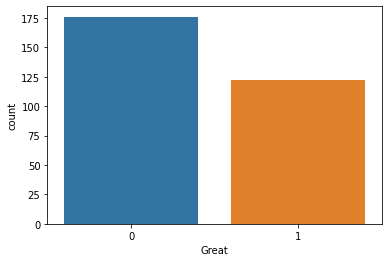

In [68]:
import seaborn as sns
# the visual communcation of information is almost more important
# that your abilities to comminicate it in comments
print(y_train.value_counts(normalize=True))
sns.countplot(y_train);

What if we guessed the majority class for every prediction?

In [69]:
majority_class = y_train.mode()[0] #what is the mode - the most common in column[0] 
majority_class

0

In [0]:
y_pred = [majority_class]  * len(y_train) # assume each one NOT GREAT
#y_pred

What is the baseline accuracy if we guessed the majority class for every prediction?

In [71]:
from sklearn.metrics import accuracy_score

baseline_train_accuracy_score = accuracy_score(y_train, y_pred)
baseline_train_accuracy_score

0.5906040268456376

In [72]:
y_val = val[target]
y_pred = [majority_class]  * len(y_val) # assume 
baseline_val_accuracy_score = accuracy_score(y_val, y_pred)
baseline_val_accuracy_score

0.5529411764705883

Use scikit-learn for logistic regression.
=========


In [73]:
# During Intial EDA, we dropped the columns with uniform Zero (0) values
train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24
Tortilla,298.0,3.472315,0.797606,1.40,3.0000,3.50,4.00,5.00
Temp,283.0,3.706360,0.991897,1.00,3.0000,4.00,4.50,5.00
Meat,288.0,3.551215,0.869483,1.00,3.0000,3.50,4.00,5.00


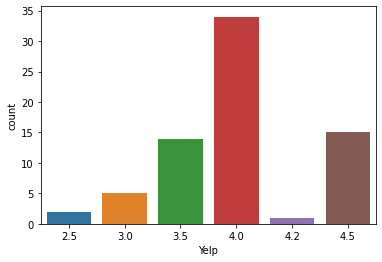

In [74]:
# note there are NaNs
# how to deal with them

column_header = train['Yelp']

#print(column_header.value_counts())
#print(column_header.mode())
sns.countplot(column_header);

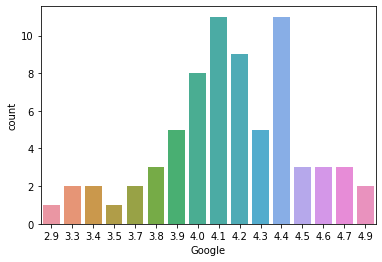

In [75]:
column_header = train['Google']

#print(column_header.value_counts())
sns.countplot(column_header);

In [76]:
# After further EDA, the ingredients of the Burrito have three possible values
#. 'x' - assuming reg amount of this ingredient
#. 'X' - assuming eXtra amount of this ingredient
#. NaT - assuming none of this ingredient
train.describe(exclude='number')

,Burrito,Date,Chips
count,298,298,22.0
unique,5,110,2.0
top,California,2016-08-30 00:00:00,5.0
freq,118,29,19.0
first,NaN,2011-05-16 00:00:00,NaN
last,NaN,2016-12-15 00:00:00,NaN


In [77]:
train.describe(exclude='number').columns

Index(['Burrito', 'Date', 'Chips'], dtype='object')

California     0.395973
Other          0.369128
Asada          0.117450
Surf & Turf    0.070470
Carnitas       0.046980
Name: Burrito, dtype: float64


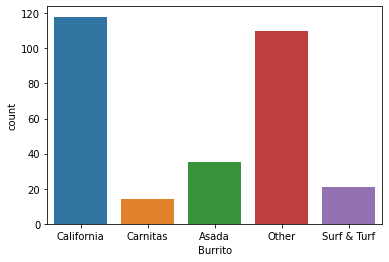

In [78]:
column_header = train['Burrito']

print(column_header.value_counts(normalize=True))
sns.countplot(column_header);

5.0     121
10.0     28
Name: Cheese, dtype: int64


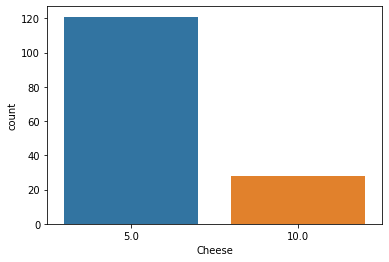

In [79]:
column_header = train['Cheese']

print(column_header.value_counts())
sns.countplot(column_header);

5.0     3
10.0    2
Name: NonSD, dtype: int64


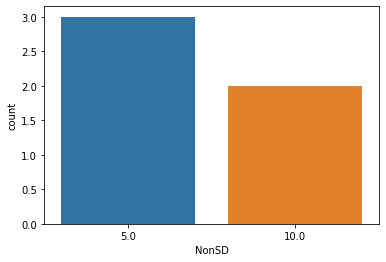

In [80]:
column_header = train['NonSD']

print(column_header.value_counts())
sns.countplot(column_header);

In [0]:
# numerical values cleaned
# categorical values NaN have been zero
#. still have to encoded them OneHotEncoding or Ordina

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

In [82]:
train.shape

(298, 56)

In [0]:
# we have 56 columns above it state to create 10 dimensional model 
# 10 dimensions == 10 features
#
# Game Plan
#. total_Ingredients
#. use physical dimensions
#. internet comments google and yelp

Fit this sequence of transformers & estimator:

- [category_encoders.one_hot.OneHotEncoder](https://contrib.scikit-learn.org/categorical-encoding/onehot.html)
- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Get validation accuracy.

### Logistic Regression! is Classification

In [0]:
filler = ['Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce',
       'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini']

In [0]:
train = train.copy()
val = val.copy()
test = test.copy()

train['total_filler'] = train[filler].sum(axis=1)
val['total_filler'] = val[filler].sum(axis=1)
test['total_filler'] = test[filler].sum(axis=1)

In [86]:
features = [ 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'total_filler']
       
train[features].head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,total_filler
0,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,25.0
1,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,25.0
2,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,15.0
3,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,15.0
4,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,20.0


In [0]:
target = 'Great'

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [88]:
encoder = ce.OneHotEncoder(use_cat_names=True)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_encoded.sample(2)

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,total_filler
235,6.95,3.5,3.5,3.5,3.0,4.0,3.0,3.0,4.5,3.5,2.0,60.0
5,6.99,4.0,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,40.0


In [0]:
# Let's take care of those NaNs
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [90]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)
X_train_imputed.sample(2)

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,total_filler
191,8.25,4.0,3.0,2.5,3.0,3.0,3.0,3.0,3.5,3.0,3.0,30.0
21,8.75,3.5,1.5,2.0,3.0,3.5,4.0,1.0,3.5,4.5,4.0,20.0


In [0]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [92]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_train_scaled.sample(2)

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,total_filler
196,1.130415,-0.524307,-0.593162,-0.732054,0.525950,-0.022447,-0.514382,-1.288309,0.187274,-0.043805,0.038686,0.789187
57,1.548091,-0.524307,0.662698,1.340696,-0.645992,1.747487,-0.514382,-1.288309,0.721245,-0.588603,0.899679,0.143094


In [93]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# check Model with Val Data
y_pred = model.predict(X_val_scaled)
val_accuracy_score = accuracy_score(y_val, y_pred)
val_accuracy_score

0.788235294117647

In [106]:
# Check Model with Test Data

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

y_pred = model.predict(X_test_scaled)
test_accuracy_score = accuracy_score(y_test, y_pred)
test_accuracy_score

0.8421052631578947

Our Results for our model 
=======

In [111]:
print(f'\nOur model has improved : {(test_accuracy_score-baseline_val_accuracy_score):,.4f}')
print('-'*20)
print(f'from baseline   : {baseline_val_accuracy_score:,.4f}')
print(f'to test         : {test_accuracy_score:,.4f}')
print('\nOur Model uses the Following Features : ')
print(features)


Our model has improved : 0.2892
--------------------
from baseline   : 0.5529
to test         : 0.8421

Our Model uses the Following Features : 
['Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']


Previous Features used
=============

The following cells are previous features 
that were used in our model 
along with their accuracy score for that run.

In [0]:
# the following cells are previous features that were used in our model 
# along with their accuracy score for that run.

In [0]:
# final feature selections
features = [ 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'total_filler']

In [0]:
features = [ 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap','Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce','Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini']

# taking out 'Yelp', 'Google','Length', 'Circum', 'Volume'

# Accuracy Score Val  : 0.8
# Accuracy Score Test : 0.8158

In [0]:
features = [ 'Cost', 'Hunger','Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap','Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce','Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini']
# taking out 'Yelp', 'Google',

# Accuracy Score Val  : 0.7882
# Accuracy Score Test : 0.8158

In [0]:
#for the following features
features = ['Yelp', 'Google', 'Cost', 'Hunger','Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap','Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
       'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce','Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
       'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
       'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
       'Corn', 'Zucchini']

# Accuracy Score Val  : 0.7647
# Accuracy Score Test : 0.8158